<a href="https://colab.research.google.com/github/EyeofaThous/AAE590/blob/main/AAE590HW5Prob1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

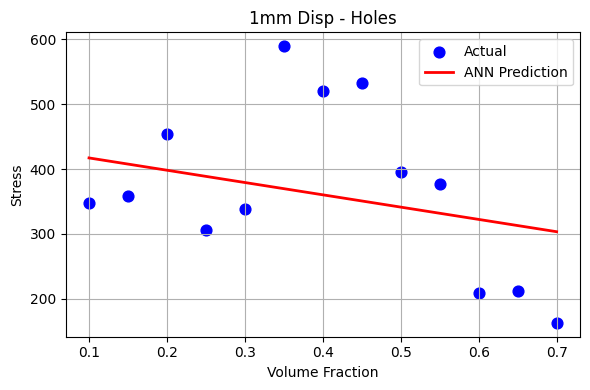

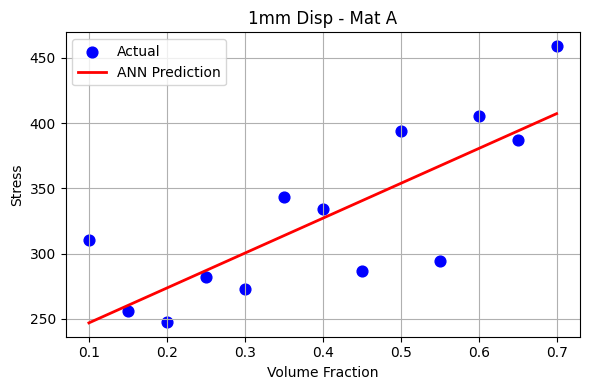

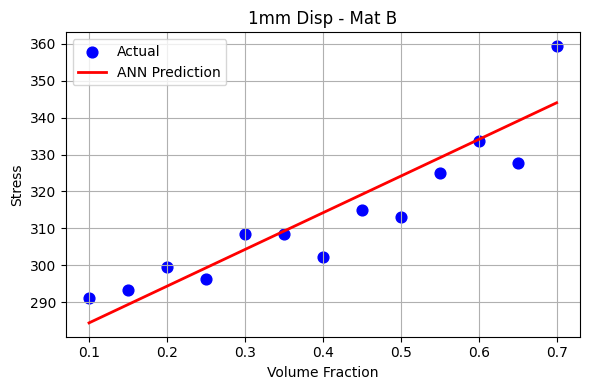

<ipython-input-5-7fb279488ee8>:57: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, _ = pearsonr(y_test_np, pred)
<ipython-input-5-7fb279488ee8>:57: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, _ = pearsonr(y_test_np, pred)


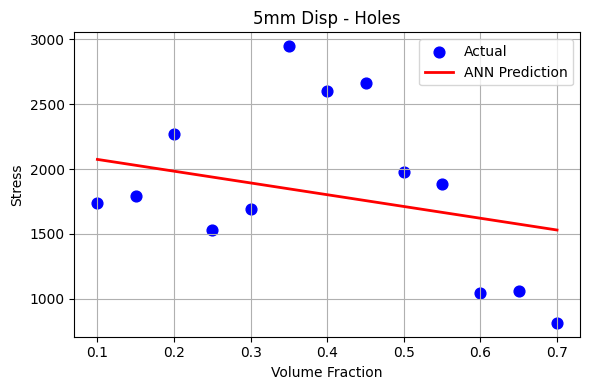

<ipython-input-5-7fb279488ee8>:57: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, _ = pearsonr(y_test_np, pred)


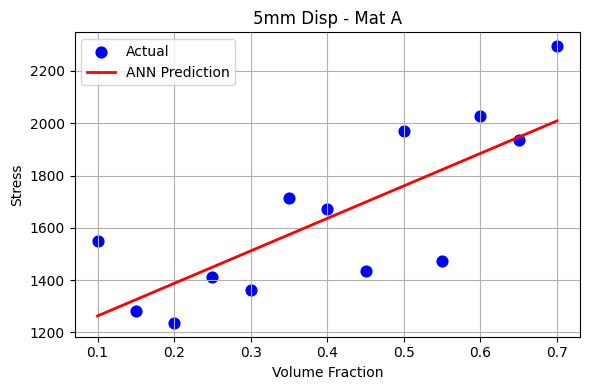

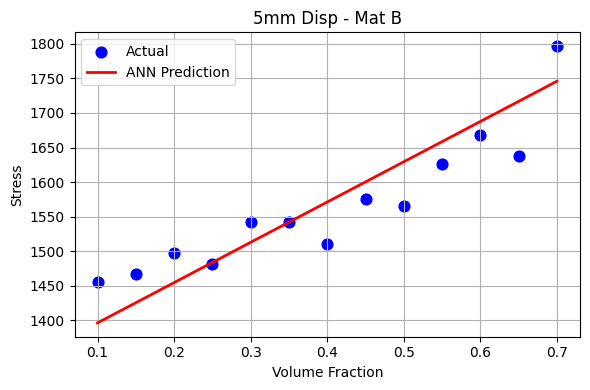

<ipython-input-5-7fb279488ee8>:57: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, _ = pearsonr(y_test_np, pred)


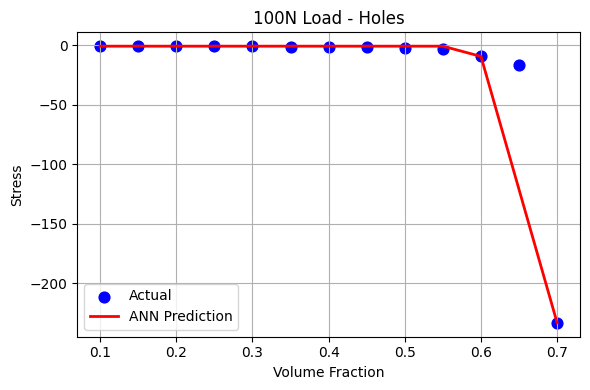

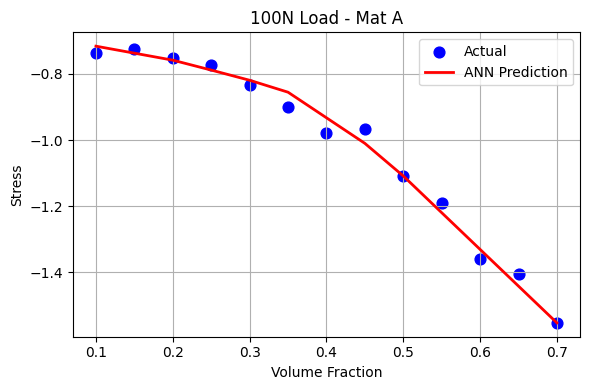

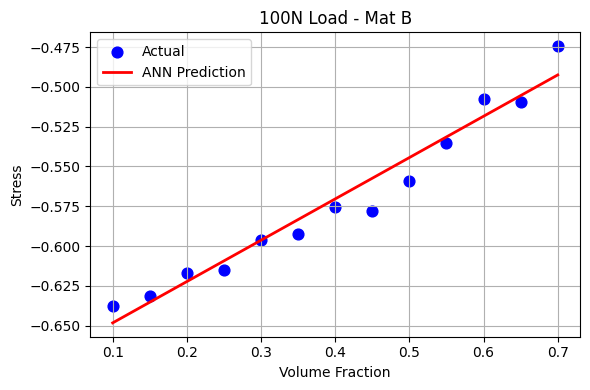

<ipython-input-5-7fb279488ee8>:57: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, _ = pearsonr(y_test_np, pred)


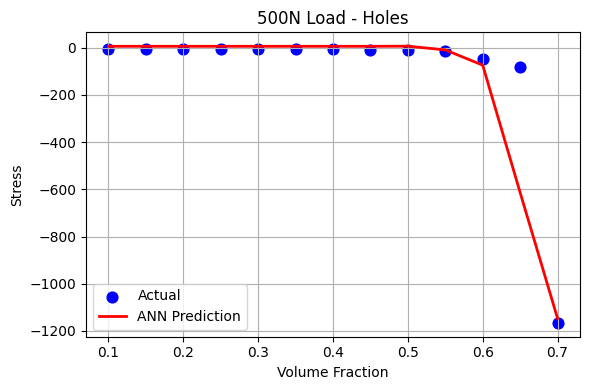

<ipython-input-5-7fb279488ee8>:57: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, _ = pearsonr(y_test_np, pred)


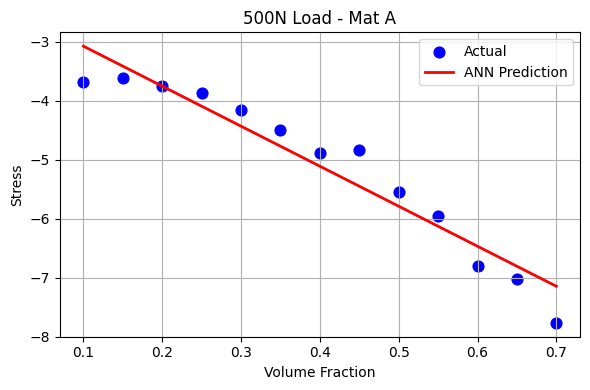

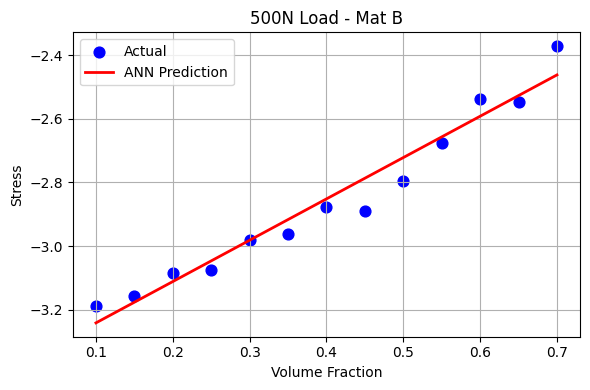


=== ANN Regression Results ===
1mm Disp - Holes | R²: -10.1327 | Pearson r: 0.7170
1mm Disp - Mat A | R²: -1.0764 | Pearson r: 0.4868
1mm Disp - Mat B | R²: 0.0686 | Pearson r: 0.9199
5mm Disp - Holes | R²: -3.8723 | Pearson r: 0.2478
5mm Disp - Mat A | R²: -10.2106 | Pearson r: 0.6868
5mm Disp - Mat B | R²: -3.1120 | Pearson r: 0.9199
100N Load - Holes | R²: -26.4716 | Pearson r: 0.0042
100N Load - Mat A | R²: 0.4976 | Pearson r: 0.9881
100N Load - Mat B | R²: 0.7523 | Pearson r: 0.9733
500N Load - Holes | R²: -562.4507 | Pearson r: 0.9993
500N Load - Mat A | R²: 0.3673 | Pearson r: 0.9921
500N Load - Mat B | R²: 0.7359 | Pearson r: 0.9738


In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

# -----------------------------
# ANN Model Definition
# -----------------------------
class ANN(nn.Module):
    def __init__(self):
        super(ANN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 1)
        )

    def forward(self, x):
        return self.net(x)

# -----------------------------
# Training Function
# -----------------------------
def train_ann(X_train, y_train, X_test, y_test):
    model = ANN()
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    epochs = 1000

    X_train_t = torch.FloatTensor(X_train)
    y_train_t = torch.FloatTensor(y_train).view(-1, 1)
    X_test_t = torch.FloatTensor(X_test)
    y_test_t = torch.FloatTensor(y_test).view(-1, 1)

    for _ in range(epochs):
        model.train()
        y_pred = model(X_train_t)
        loss = loss_fn(y_pred, y_train_t)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    with torch.no_grad():
        pred = model(X_test_t).numpy().flatten()
        y_test_np = y_test_t.numpy().flatten()

        if np.all(y_test_np == y_test_np[0]):
            return np.nan, np.nan, model

        r2 = r2_score(y_test_np, pred)
        r, _ = pearsonr(y_test_np, pred)
        return r2, r, model

# -----------------------------
# Plotting Function
# -----------------------------
def plot_predictions(model, X_all, y_all, title):
    model.eval()
    with torch.no_grad():
        X_tensor = torch.FloatTensor(X_all)
        predictions = model(X_tensor).numpy().flatten()

    plt.figure(figsize=(6, 4))
    plt.scatter(X_all, y_all, color='blue', label='Actual', s=60)
    plt.plot(X_all, predictions, color='red', label='ANN Prediction', linewidth=2)
    plt.xlabel('Volume Fraction')
    plt.ylabel('Stress')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# -----------------------------
# Main Script
# -----------------------------
excel_path = '590DataSet1.xlsx'  # <-- UPDATE this to your file path
sheet_names = pd.ExcelFile(excel_path).sheet_names
materials = ['Holes', 'Mat A', 'Mat B']

results = []

for sheet in sheet_names:
    df = pd.read_excel(excel_path, sheet_name=sheet)
    if 'Volume Fraction' not in df.columns:
        continue  # skip malformed sheets

    for mat in materials:
        if mat not in df.columns:
            continue

        X_all = df['Volume Fraction'].values.reshape(-1, 1)
        y_all = df[mat].values

        kf = KFold(n_splits=5, shuffle=True, random_state=1)
        r2_list, r_list = [], []
        final_model = None

        for train_idx, test_idx in kf.split(X_all):
            X_train, X_test = X_all[train_idx], X_all[test_idx]
            y_train, y_test = y_all[train_idx], y_all[test_idx]
            r2, r, model = train_ann(X_train, y_train, X_test, y_test)
            if not np.isnan(r2):
                r2_list.append(r2)
                r_list.append(r)
                final_model = model  # Keep last valid model

        mean_r2 = np.nanmean(r2_list)
        mean_r = np.nanmean(r_list)
        results.append((sheet, mat, mean_r2, mean_r))

        if final_model is not None:
            plot_predictions(final_model, X_all, y_all, f"{sheet} - {mat}")

# -----------------------------
# Print Summary Results
# -----------------------------
print("\n=== ANN Regression Results ===")
for sheet, mat, r2, r in results:
    print(f"{sheet} - {mat} | R²: {r2:.4f} | Pearson r: {r:.4f}")

